In [6]:
! pip install 'cebra[dev,demos]' 

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: No such file or directory
/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: exec: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: cannot execute: No such file or directory


In [7]:
import sys

import os # my addtion

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
#import joblib as jl
import cebra.datasets
from cebra import CEBRA
import torch

from matplotlib.collections import LineCollection
import pandas as pd

import pickle
import sklearn.linear_model
from sklearn import manifold
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# custom function
import d_library as dl

In [8]:
# Load the NM data
neural_data = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA capsule/neural_data.pkl', "rb"))

In [9]:
# set max iterations
iterations = 1000

### Simple test 

Checking the embeddings produced by CEBRA. Do they make sense?
Here, we use a 2D circle as input and monitor if the general shape/dimension changes in the output.

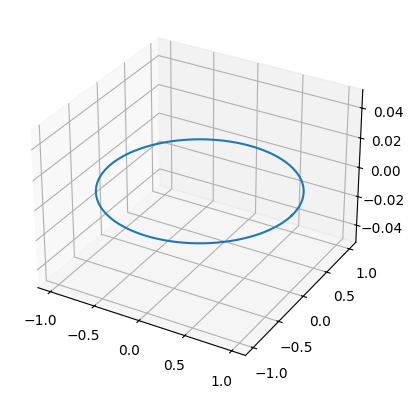

(100, 3)

In [10]:
circle = dl.make_circle()
dl.plot_circle(circle[:,0], circle[:,1])
circle.shape

In [11]:
circle_r3 = dl.make_circle(r=3)
circle_r5 = dl.make_circle(r=5)


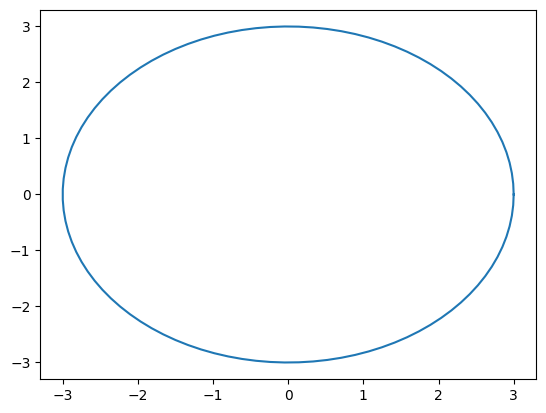

In [12]:
plt.plot(circle_r3[:,0], circle_r3[:,1])

In [13]:
# Make a function to build a model, train it and then compute an embedding

def get_embed(input, dimension=3):

    # build CEBRA time model
    model = CEBRA(model_architecture='offset10-model',
                         batch_size=512,
                         learning_rate=0.01,
                         temperature=1,
                         output_dimension = int(dimension),
                         max_iterations=iterations,
                         distance='cosine',
                         conditional='time',
                         device='cuda_if_available',
                         num_hidden_units=64,
                         verbose=True,
                         time_offsets=1)

    model.fit(input)
    embedding = model.transform(input)


    return model, embedding


In [14]:
circle_r3.shape

(100, 3)

In [15]:
model_r3, embed_r3 = get_embed(circle_r3,dimension=2)
model_r5, embed_r5 = get_embed(circle_r5,dimension=2)

pos: -0.9982 neg:  6.4748 total:  5.4766 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 70.10it/s]
pos: -0.9982 neg:  6.4755 total:  5.4773 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 73.46it/s]


In [16]:
model_r3_1d, embed_r3_1d = get_embed(circle_r3,dimension=1)
model_r5_1d, embed_r_1d = get_embed(circle_r5,dimension=1)

pos: -0.9844 neg:  6.6873 total:  5.7029 temperature:  1.0000: 100%|██████████| 1000/1000 [00:15<00:00, 64.24it/s]
pos: -1.0000 neg:  7.2383 total:  6.2383 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 69.57it/s]


In [17]:
embed_r_1d

array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
      

### OBSERVATION

All the circles of different radii are being transformed into a 2d circle of radius 1 by CEBRA! Information about their size is being lost, but they still remain circles in 2D.

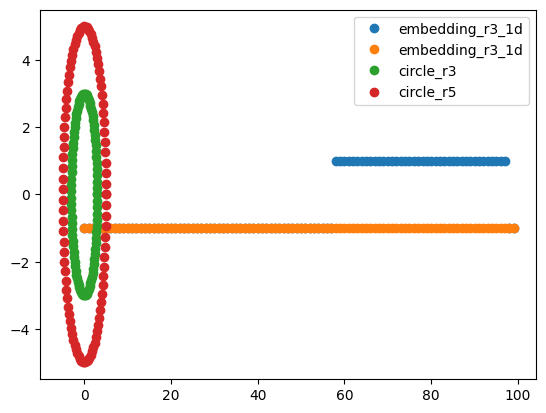

In [18]:
# plt.plot(embed_r3[:,0],embed_r3[:,1],'o', label='embedding_r3')
# plt.plot(embed_r5[:,0],embed_r5[:,1],'o', label='embedding_r3')

plt.plot(embed_r3_1d[:,0],'o', label='embedding_r3_1d')
plt.plot(embed_r_1d[:,0],'o', label='embedding_r3_1d')
plt.plot(circle_r3[:,0], circle_r3[:,1],'o', label='circle_r3')
plt.plot(circle_r5[:,0], circle_r5[:,1],'o', label='circle_r5')
plt.legend()
plt.show()

Ok, now add some additive independent noise to individual points.

from Uygar --  you could move the points in time without moving ahead/behind its neighbors. e.g., if x(t) is true, you could try x(t+tau) + n, where n is zero-mean Gaussian and tau is uniformly distributed between (-0.5, 0.5) if each point is one step ahead of the previous one. i.e., t, t+1, t+2, ...

In [19]:
# tau is uniformly distributed noise between (-0.5, 0.5)
tau = np.random.uniform(-0.5,0.5, size=100)

# n is zero-mean additive Gaussian noise
n = np.random.normal(scale=0.1,size=100)

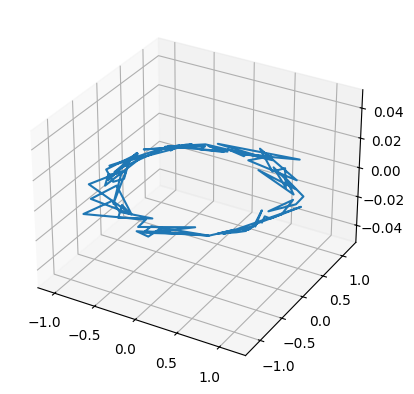

In [20]:
# add the noise to the initial input

# Create a figure and axis
fig0 = plt.figure()
ax0 = plt.subplot(111,projection='3d')

# Define the center and radius of the circle
center = (0, 0)
radius = 1

# Create an array of angles from 0 to 2*pi
theta = np.linspace(0, 2*np.pi, 100)

# Calculate the x and y coordinates of the circle with the additive noise
x = center[0] + radius * np.cos(theta+ tau) + n 
y = center[1] + radius * np.sin(theta + tau) + n

# add the 3rd dimension (z coordinate of 0)
z = np.zeros(100) 

# Plot the circle
ax0.plot(x, y, z, label='Circle')

# Show the plot
plt.show()

In [21]:
coords_0 = np.array([x,y,z])
coords_0 = np.reshape(coords_0, (100,3))


In [22]:
# CEBRA Time
cebra_time_model_c1 = CEBRA(model_architecture='offset10-model',
                         batch_size=512,
                         learning_rate=0.01,
                         temperature_mode='auto',
                         max_iterations=iterations,
                         distance='cosine',
                         conditional='time',
                         device='cuda_if_available',
                         num_hidden_units=64,
                         verbose=True,
                         time_offsets=1)

cebra_time_model_c1.fit(coords_0)
cebra_time_embedding_c1 = cebra_time_model_c1.transform(coords_0)

pos: -9.6258 neg:  13.2787 total:  3.6529 temperature:  0.1000: 100%|██████████| 1000/1000 [00:15<00:00, 63.35it/s]


<Axes: xlabel='Steps', ylabel='InfoNCE Loss'>

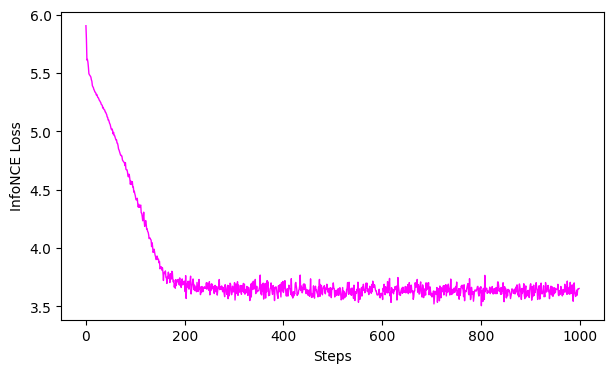

In [23]:
cebra.plot_loss(cebra_time_model_c1)

<Axes3D: title={'center': 'Embedding'}>

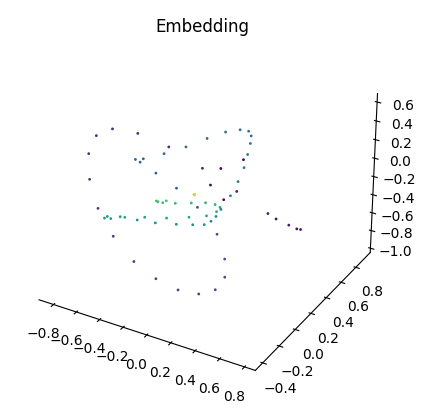

In [24]:
cebra.plot_embedding(cebra_time_embedding_c1, markersize=1, alpha=1, embedding_labels='time')

Now, let's apply a non-linear transformation f to the circle and see if CEBRA is able to retrieve the loop topology.

The transformation we'll first apply will be one that twists the circle.

In [25]:
# function that makes the circle and adds the noise and time/theta displacement
def noisy_circle(a=1, b=0.1):

    # tau is uniformly distributed noise between (-0.5, 0.5)
    tau = a*np.random.uniform(-0.5,0.5, size=100)

    # n is zero-mean additive Gaussian noise
    n = np.random.normal(scale=b,size=100)

    # Calculate the x and y coordinates of the circle with the additive noise
    x = center[0] + radius * np.cos(theta + tau) + n 
    x = x.reshape(-1,1)
    y = center[1] + radius * np.sin(theta + tau) + n
    y = y.reshape(-1,1)

    # add the 3rd dimension (z coordinate of 0)
    z = np.zeros(100) 
    z = z.reshape(-1,1)

    n_circle = np.concatenate((x,y,z), axis=1)

    return n_circle

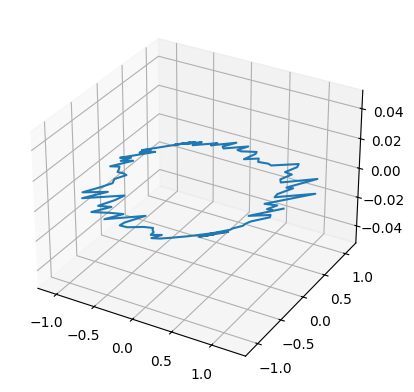

In [26]:
# Create a figure and axis and then plot the noisy circle
fig1 = plt.figure()
ax1 = plt.subplot(111,projection='3d')
circle_2 = noisy_circle(a=0.03)
ax1.plot(circle_2[:,0],circle_2[:,1])

In [27]:
# function to twist the circle
def twist_circle(circle, twist_factor, n_points=100):

    # Create an array of angles from 0 to 2*pi
    theta = np.linspace(0, 2*np.pi, n_points)

    r = 1.0  # Radius of the circle
    twisted_r = r + twist_factor * np.sin(5 * theta)  # Twisting function

    # apply it on all coordinates
    t_x = twisted_r * np.cos(theta)
    t_x = t_x.reshape(-1,1)

    t_y  = twisted_r * np.sin(theta)
    t_y = t_y.reshape(-1,1) 

    t_z = np.zeros(100)
    t_z = t_z.reshape(-1,1)

    twisted_circle = np.concatenate((t_x, t_y, t_z), axis=1)

    return twisted_circle

In [29]:
c1 = dl.make_circle()

## Quantifying the model performance in reconstructing the input data

Let's now make a function to tell us how well the model is computing the reconstructed embeddings.

In [30]:
def reconstruction_score(x, y):

    def _linear_fitting(x, y):
        lin_model = sklearn.linear_model.LinearRegression()
        lin_model.fit(x, y)
        return lin_model.score(x, y), lin_model.predict(x)

    return _linear_fitting(x, y)

In [31]:
# make an ellipse
def plot_ellipse(n_points=100):

    u=0     #x-position of the center
    v=0   #y-position of the center
    a=2.     #radius on the x-axis
    b=1.5    #radius on the y-axis

    t = np.linspace(0, 2*np.pi, n_points)
    plt.plot( u+a*np.cos(t) , v+b*np.sin(t) )
    plt.grid(color='lightgray',linestyle='--')
    plt.show()

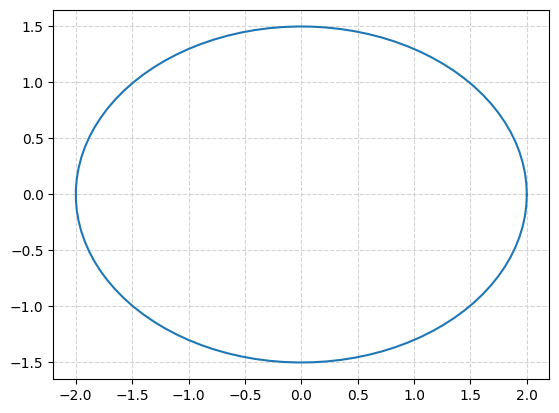

In [32]:
plot_ellipse()

In [33]:
def make_ellipse(n_points=100):
    u=0    #x-position of the center
    v=0    #y-position of the center
    a=2.   #radius on the x-axis
    b=0.2  #radius on the y-axis

    theta = np.linspace(0, 2*np.pi, n_points)

    x = u+a*np.cos(theta)
    x = x.reshape(-1,1)
    
    y = v+b*np.sin(theta)
    y = y.reshape(-1,1)

    # add the 3rd dimension (z coordinate of 0)
    z = np.zeros(n_points)
    z = z.reshape(-1,1)

    ellipse = np.concatenate((x,y,z), axis=1)

    return ellipse
    

In [34]:
ellipse1 = make_ellipse()

In [35]:
circle1 = dl.make_circle()

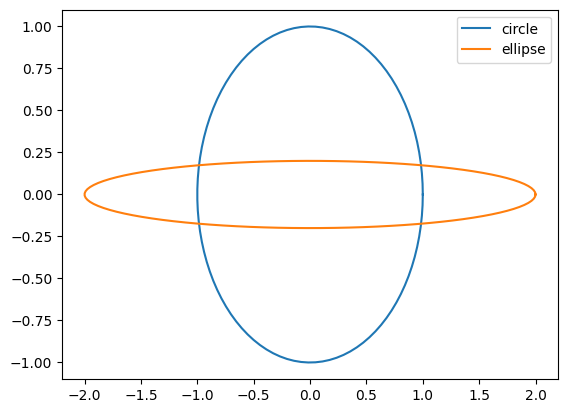

In [36]:
plt.plot(circle1[:,0], circle1[:,1], label='circle')
plt.plot(ellipse1[:,0], ellipse1[:,1], label='ellipse')
plt.legend()
plt.show()


In [37]:
circle2 = noisy_circle()

In [38]:
# function to get model score + embedding
def get_model_score(data, output_dimension):

    # define a list to hold the scores
    scores =[]

    # get several embeddings and take the average r2 score
    for i in range(0,5):
        # build model and get embedding -- later on edit this to keep the best 1
        model, embedding = get_embed(data, dimension = output_dimension)

        # get r2 score
        model_score, prediction = reconstruction_score(embedding,data)
        scores.append(model_score)

        # conditional to keep the best model here
    
    # get the average
    best = np.mean(scores)
    low = np.min(scores)
    high = np.max(scores)

    model_scores = np.array([best,best-low,high-best])

    return model_scores, embedding

In [39]:
model, output_3d = get_embed(circle1[:,:2], dimension = 3)

pos: -0.9947 neg:  6.3992 total:  5.4046 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 67.91it/s]


In [40]:
model_e, embed_e = get_embed(ellipse1, dimension=2)

pos: -0.9936 neg:  6.4793 total:  5.4857 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 70.87it/s]


In [41]:
model_e1, embed_e1 = get_embed(ellipse1, dimension=1)

pos: -0.9453 neg:  6.6722 total:  5.7269 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 70.78it/s]


<Axes: title={'center': 'Embedding'}>

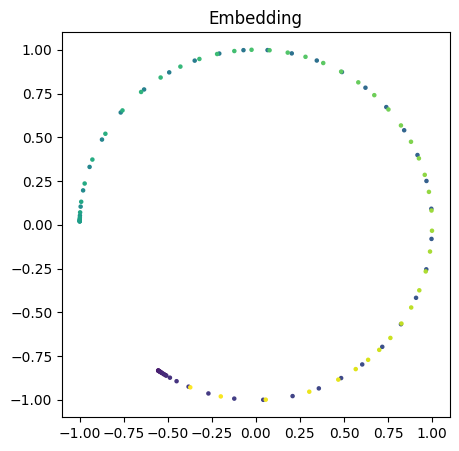

In [42]:
cebra.plot_embedding(embed_e, markersize=5, alpha=1, embedding_labels='time')

In [47]:
scores, embedding_eg = get_model_score(circle1,2)

  0%|          | 0/1000 [00:00<?, ?it/s]

pos: -0.9981 neg:  6.4677 total:  5.4696 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 69.12it/s]
pos: -0.9983 neg:  6.4747 total:  5.4764 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 73.79it/s]
pos: -0.9981 neg:  6.4753 total:  5.4772 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.71it/s]
pos: -0.9981 neg:  6.4741 total:  5.4760 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.36it/s]
pos: -0.9982 neg:  6.4766 total:  5.4784 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.59it/s]


In [48]:
scores

array([0.99724953, 0.00170575, 0.0011903 ])

In [49]:
# get the r2 scores at different dimensions for the circles and compare
scores_a1d, embedding_a1d = get_model_score(circle1,1)

pos: -0.9531 neg:  6.6730 total:  5.7199 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 71.93it/s]
pos: -0.9570 neg:  6.6958 total:  5.7387 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 71.88it/s]
pos: -0.9570 neg:  7.0727 total:  6.1157 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.13it/s]
pos: -0.9766 neg:  6.6719 total:  5.6953 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.52it/s]
pos: -0.9648 neg:  6.6728 total:  5.7079 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.79it/s]


In [50]:
print('score:',scores_a1d)
print('embedding shape:', embedding_a1d.shape)

score: [0.55268978 0.19141801 0.05091278]
embedding shape: (100, 1)


Plot the ellipse and the 1d embedding produced by CEBRA

NameError: name 'embedding_1d' is not defined

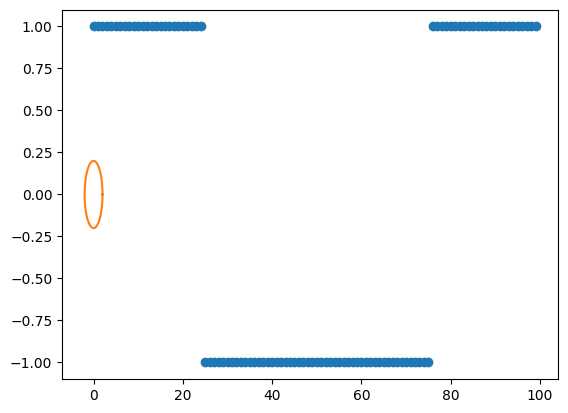

In [51]:
plt.plot(embed_e1[:,0],'o', label='embedding')
plt.plot(ellipse1[:,0], ellipse1[:,1], label='input')
plt.plot(embedding_1d[:,0],'*', label='circle_1d_embedding')
plt.legend()

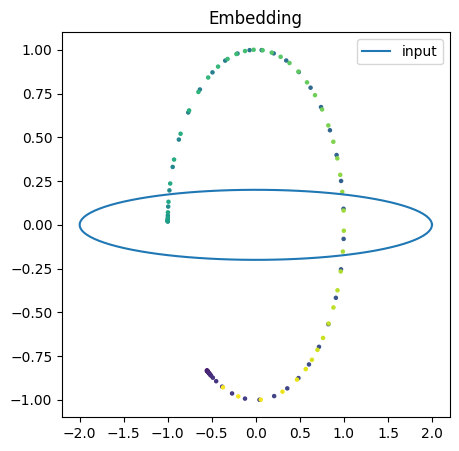

In [52]:
cebra.plot_embedding(embedding=embed_e, embedding_labels='time', markersize=5, alpha=1)
plt.plot(ellipse1[:,0], ellipse1[:,1], label='input')
plt.legend()

<Axes: title={'center': 'Embedding'}>

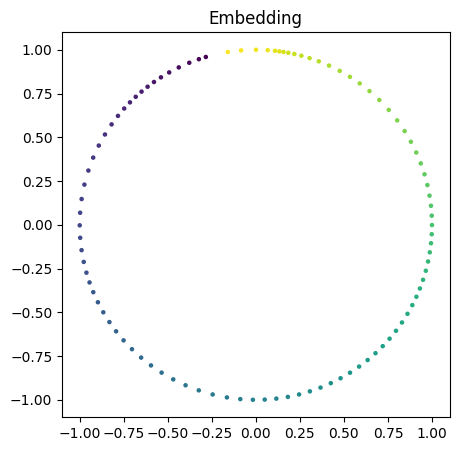

In [53]:
cebra.plot_embedding(embedding=embedding_eg, embedding_labels='time', markersize=5, alpha=1)

In [54]:
scores_1d, embedding_1d = get_model_score(circle1[:,:2],output_dimension=1)

pos: -0.9414 neg:  6.6728 total:  5.7314 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 70.55it/s]
pos: -0.9805 neg:  6.6830 total:  5.7026 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.68it/s]
pos: -0.9648 neg:  6.6831 total:  5.7183 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 73.12it/s]
pos: -0.9805 neg:  6.6728 total:  5.6924 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 71.12it/s]
pos: -1.0000 neg:  7.2383 total:  6.2383 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 71.90it/s]


In [55]:
scores_1d

array([0.31980223, 0.31980223, 0.08494234])

In [56]:
embedding_eg.shape

(100, 2)

In [57]:
# make plots for all the embeddings vs the inputs
def plot_embed_input(input,dimension):

    scores, output = get_model_score(input, dimension)
    ax = cebra.plot_embedding(embedding = output,  markersize=4, alpha=1, embedding_labels='time')
    ax.plot(input[:,0],input[:,1], label='input data')
    ax.legend()

pos: -0.9982 neg:  6.4755 total:  5.4773 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 68.32it/s]
pos: -0.9983 neg:  6.4778 total:  5.4794 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 71.83it/s]
pos: -0.9982 neg:  6.4732 total:  5.4749 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 71.39it/s]
pos: -0.9983 neg:  6.4721 total:  5.4738 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 68.69it/s]
pos: -0.9981 neg:  6.4729 total:  5.4748 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 71.26it/s]


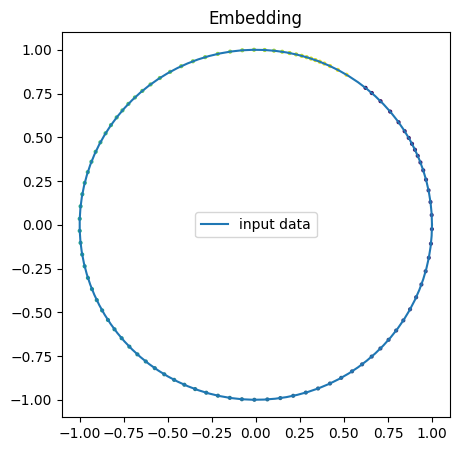

In [58]:
plot_embed_input(circle1,2)

  0%|          | 0/1000 [00:00<?, ?it/s]

pos: -0.9951 neg:  6.4014 total:  5.4063 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 69.89it/s]
pos: -0.9950 neg:  6.4019 total:  5.4069 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 70.43it/s]
pos: -0.9948 neg:  6.3993 total:  5.4045 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 70.55it/s]
pos: -0.9949 neg:  6.4007 total:  5.4058 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 69.95it/s]
pos: -0.9948 neg:  6.4012 total:  5.4064 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 69.87it/s]


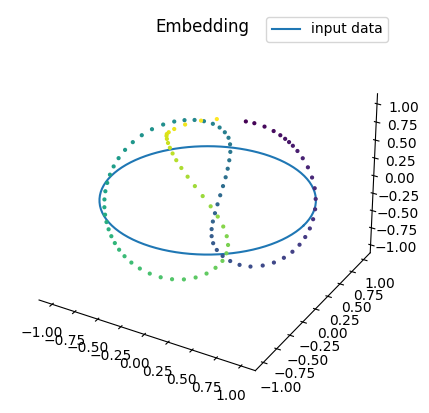

In [59]:
plot_embed_input(circle1,3)

In [60]:
def analyse_embedding(input_set, n_dimensions):

    #  make a loop to analyse the embedding produced for each of the data inputs
    scores = []
    for circle in input_set:
        model_scores, output = get_model_score(circle, n_dimensions)
        scores.append(model_scores[0])

        plot_embed_input(circle,n_dimensions)

    # plot the reconstruction scores
    fig = plt.figure()
    plt.plot(np.linspace(1,3,3),scores, 'o')
    plt.xlabel('Dataset number')
    plt.ylabel('Reconstruction score (R2)')
    plt.title('Reconstruction score for the different inputs in {} dimensions'.format(n_dimensions))


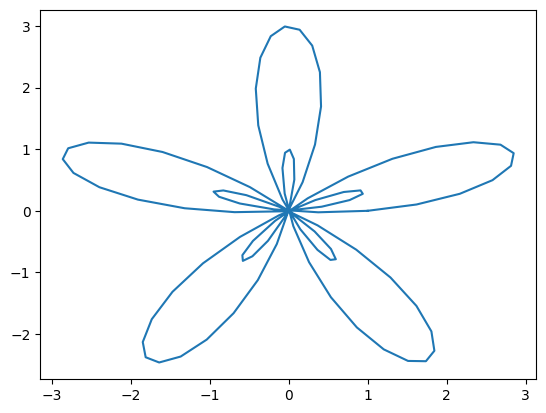

In [61]:
t_circle = twist_circle(circle1, twist_factor=2)
plt.plot(t_circle[:,0], t_circle[:,1])

In [62]:
circles = [circle1, circle_2, t_circle]

pos: -0.9983 neg:  6.4735 total:  5.4752 temperature:  1.0000: 100%|██████████| 1000/1000 [00:15<00:00, 66.62it/s]
pos: -0.9982 neg:  6.4730 total:  5.4748 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 69.60it/s]
pos: -0.9982 neg:  6.4734 total:  5.4752 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 71.46it/s]
pos: -0.9983 neg:  6.4741 total:  5.4759 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 70.87it/s]
pos: -0.9982 neg:  6.4753 total:  5.4771 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 71.15it/s]
pos: -0.9982 neg:  6.4745 total:  5.4763 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 71.91it/s]
pos: -0.9984 neg:  6.4741 total:  5.4757 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 71.86it/s]
pos: -0.9983 neg:  6.4739 total:  5.4757 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.27it/s]
pos: -0.9981 neg:  6.4752 total:  5.4771 temperature:  1.0000: 100%|██████████| 

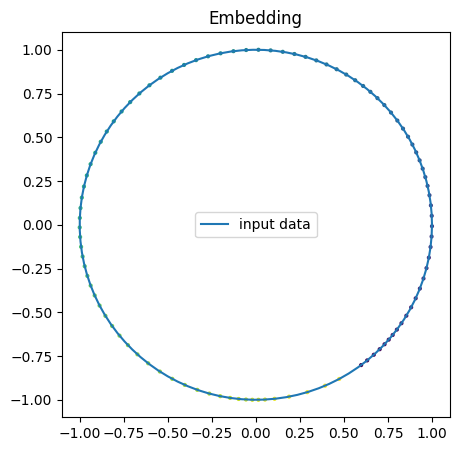

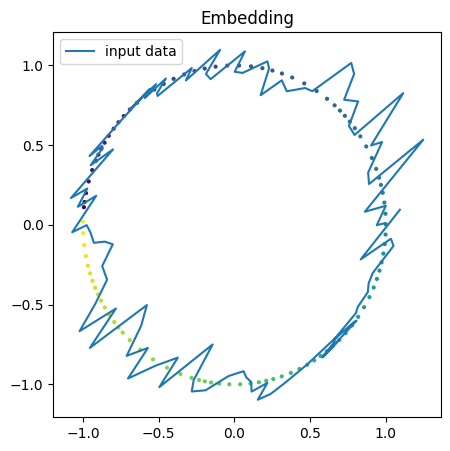

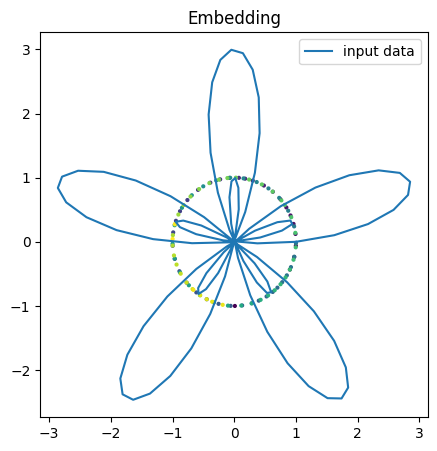

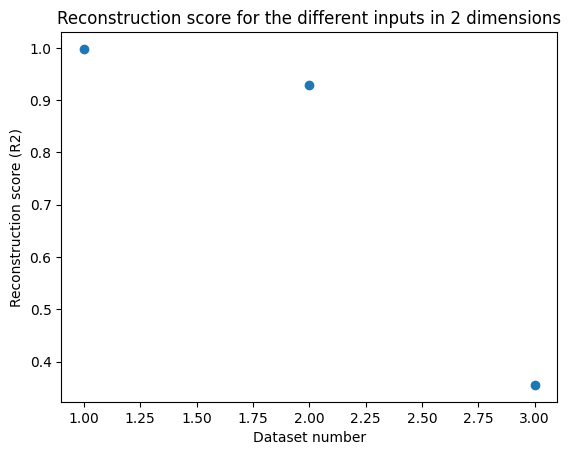

In [63]:
analyse_embedding(circles,2)

In [64]:
# function that gets the r2 scores for input dataset

# take in the dataset - new function definition
def get_r2(dataset, dimensions=[2,3,8]):

    # define list to hold the scores
    r2_scores = []

    # compute the R2 score for multiple dimensions 
    # - call getmodel score for 3 dimensions -- new loop
    for dimension in dimensions:
        r2, output = get_model_score(dataset,int(dimension))
        r2_scores.append(r2)
    
    return np.array(r2_scores)


In [65]:
names = ['original circle', 'noisy circle', 'twisted noisy circle', 'lorenz attractor']

In [66]:
# function that plots R2 vs dimensionality for input dataset

# loop over datasets and get their r2 scores at the 3 dimensions
    
def r2_vs_dimension(datasets, dimensionality=[2,3,8], labels = names):
    # define list to hold the sequence of r2 scores
    r2_sequence =[]

    # loop over all datasets
    for i in range(np.shape(datasets)[0]):
        scores = get_r2(datasets[i],dimensionality)
        r2_sequence.append(scores)

        # then plot the R2 scores at each of the 3 dimensions
        plt.errorbar(x=dimensionality, y=scores[:,0], yerr=np.transpose(scores[:,(1,2)]), fmt='o', label=labels[i])

    plt.xlabel('Dimensionality')
    plt.ylabel('R2 Score')
    plt.title('R2 vs dimensionality')
    plt.legend()
    plt.show()

    return r2_sequence


pos: -0.9648 neg:  6.7497 total:  5.7849 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 70.13it/s]
pos: -0.9883 neg:  6.7858 total:  5.7975 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.67it/s]
pos: -0.9844 neg:  6.6998 total:  5.7154 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 71.61it/s]
pos: -1.0000 neg:  7.2383 total:  6.2383 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.43it/s]
pos: -0.9570 neg:  6.7855 total:  5.8285 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.08it/s]
pos: -0.9983 neg:  6.4729 total:  5.4746 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 71.52it/s]
pos: -0.9983 neg:  6.4745 total:  5.4762 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 70.78it/s]
pos: -0.9969 neg:  6.4725 total:  5.4756 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.11it/s]
pos: -0.9982 neg:  6.4747 total:  5.4765 temperature:  1.0000: 100%|██████████| 

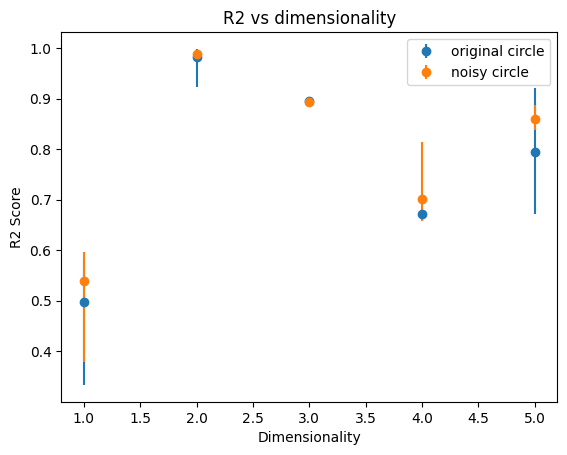

In [67]:
r2_seq = r2_vs_dimension(circles[:2],[1,2,3,4,5])

## Computing 2D version of x (one dimensional embedding)

In [68]:
from sympy import symbols, Matrix, solve, expand, diff, collect
from numpy import linalg

In [69]:
circle1[:,:2].shape

(100, 2)

In [70]:
# Define matrices
x = embedding_1d
y = circle1[:,:2]

In [71]:
# using sklearn's linear regression
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(x, y)

LinearRegression()

In [72]:
linear_model.coef_

array([[0.],
       [0.]])

In [73]:
predicted_y = linear_model.predict(x)

Now try the same thing with an input that's a sequence of numbers: we see that the y_Hat produced (here termed y_hat_test) is a line instead of a single point. So the problem wasn't the transformation matrix but maybe the embedding itself. The embedding only produces a line for y_hat if we add a second dimension that's a sequence of numbers -- otherwise it's just a single line.

In [74]:
x_test = np.linspace(1,100,100).reshape(-1,1)
x_test.shape

(100, 1)

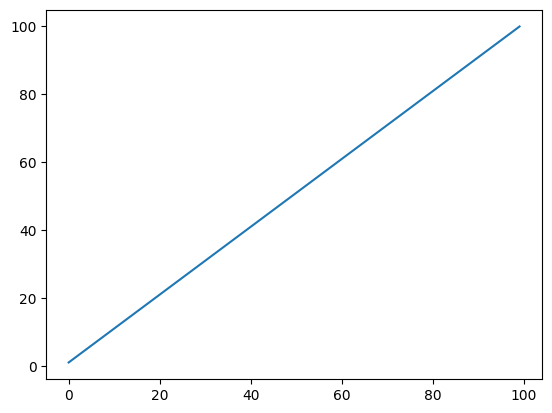

In [75]:
plt.plot(x_test)

In [76]:
def get_yhat(x,y):
    
    #make the model
    regression_model = sklearn.linear_model.LinearRegression()
    regression_model.fit(x,y)

    # get A and yhat
    A = regression_model.coef_.reshape(1,2)
    y_hat = np.dot(x,A)

    return y_hat, A


In [77]:
y_hat_test, A_test = get_yhat(x_test,y)

In [78]:
A_test

array([[ 3.84611768e-19, -1.87141190e-02]])

In [79]:
ellipse1.shape

(100, 3)

In [80]:
# same thing for the ellipse
y_hate, A_e = get_yhat(embed_e1,ellipse1[:,:2])

In [81]:
# using least squares regression from linalg
solution, residuals, rank, s = np.linalg.lstsq(x,y)

/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_16479/1359709110.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution, residuals, rank, s = np.linalg.lstsq(x,y)


In [82]:
solution

array([[ 1.00000000e-02, -1.02565526e-18]])

In [83]:
y_hat = np.dot(x,solution)

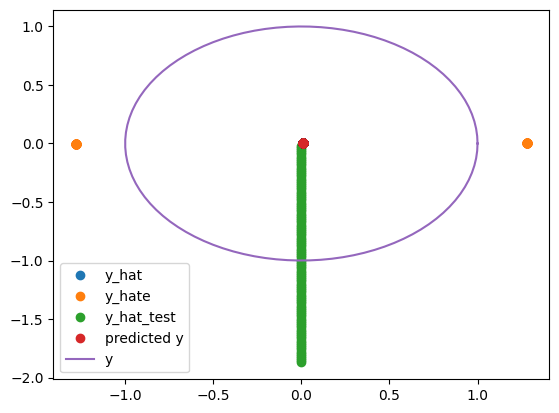

In [84]:
plt.plot(y_hat[:,0],y_hat[:,1],'o', label='y_hat')
plt.plot(y_hate[:,0],y_hate[:,1],'o', label='y_hate')
plt.plot(y_hat_test[:,0], y_hat_test[:,1],'o', label='y_hat_test')
plt.plot(predicted_y[:,0],predicted_y[:,1],'o', label='predicted y')
plt.plot(y[:,0],y[:,1],label = 'y')
plt.legend()
plt.show()